### A set of scripts to analyze the information loss in scarps associated with landscape evolution

### load Python packages

In [28]:
# First, import a few Python packages and landlab tools
import numpy as np
from pylab import show, figure, plot
import time
from landlab import RasterModelGrid
from landlab.plot.imshow import imshow_grid
from landlab.io import read_esri_ascii
import matplotlib.pyplot as plt

from osgeo import gdal
import glob
from PIL import Image
import matplotlib.cbook as cbook
import scipy.optimize
from scipy.optimize import curve_fit
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib as mpl
mpl.rcParams['font.size'] = 8

### User-defined inputs

In [42]:
n_iter = np.array([0,2,20,200,2000]) # number of iterations (total_time = n_iter * dt) at which to produce output, default dt=5 years
DEM_name = 'DEMs/rc_7_7_4_90.asc' # set name of your DEM here 
txtname = 'test.pdf' # figure name

### Calculate change in elevation distribution in landscape over time for the DEM

<>:46: SyntaxWarning: invalid escape sequence '\D'
<>:46: SyntaxWarning: invalid escape sequence '\D'
/var/folders/kg/j5ms0y1x28l_gm2jtsf5j4pr0000gn/T/ipykernel_84267/595577437.py:46: SyntaxWarning: invalid escape sequence '\D'
  fig.colorbar(im, ax=ax[plot_counter,1],label='$\Delta$ z (m)',orientation='horizontal')
/opt/homebrew/anaconda3/envs/scarp_erosion/lib/python3.12/site-packages/landlab/graph/graph.py:412: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  return self.ds.dims["node"]
/opt/homebrew/anaconda3/envs/scarp_erosion/lib/python3.12/site-packages/landlab/graph/graph.py:535: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names 

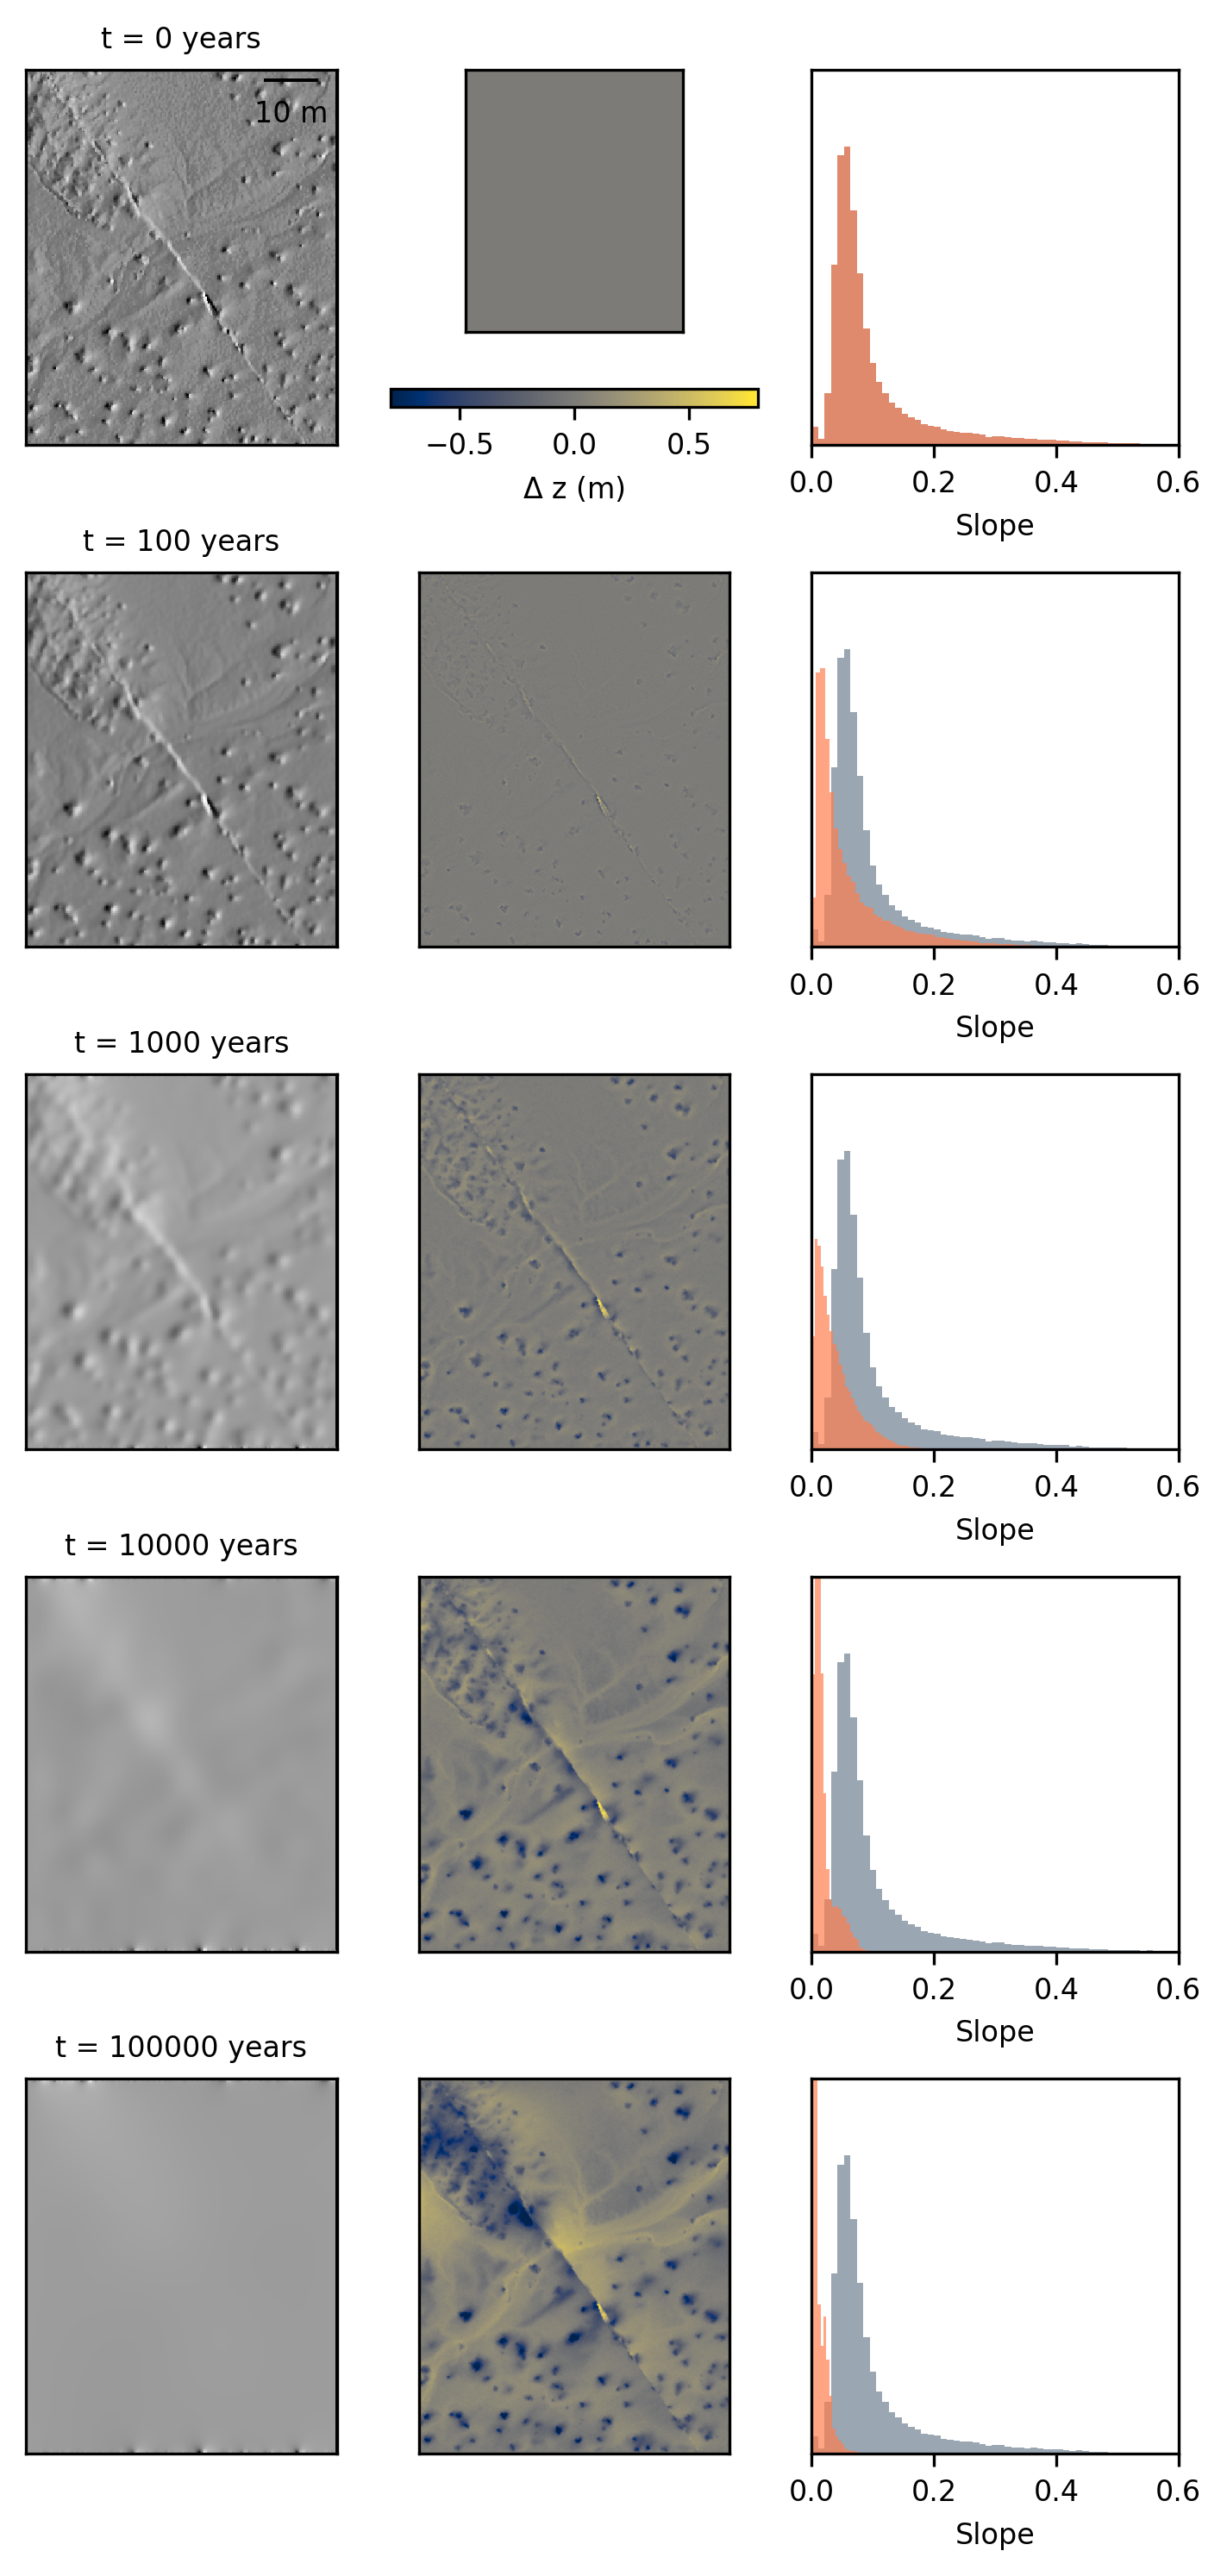

In [44]:
fig, ax = plt.subplots(
    len(n_iter),3,
    tight_layout=True,
    figsize=(5,10),
    dpi=300
)

# landlab grid from DEM
mg, z = read_esri_ascii(DEM_name, name='topographic__elevation')
mg.set_fixed_value_boundaries_at_grid_edges(False, True, False, True)
mg.set_closed_boundaries_at_grid_edges(True, False, True, False)
slope_t0 = mg.calc_slope_at_node(z)
slope_t0 = np.array(slope_t0)
z_t0 = z[mg.nodes]

# model set-up for 2D diffusion
D = 0.001  # m2/yr transport rate
dt = 0.2 * mg.dx * mg.dx / D # time step is 5 years 
mg.set_closed_boundaries_at_grid_edges(True, False, True, False)
qs = mg.add_zeros('sediment_flux', at='link')

# run model over time
def imshow_noticks(AX,MG):
    fig.sca(AX)
    hillshade = mg.calc_hillshade_at_node(elevs=z, alt=30., az=100.)
    imshow_grid(MG,hillshade,cmap='gray') # plot_type, 'Hillshade'
    AX.set_xticklabels([])
    AX.set_yticklabels([])
    AX.set_xticks([])
    AX.set_yticks([])
    AX.set_ylabel('')
    AX.set_xlabel('')
    colorbar = plt.gci().colorbar
    colorbar.remove()

plot_counter=0
for p in range(max(n_iter)+1):
    if np.any(p == n_iter):
        imshow_noticks(ax[plot_counter,0],mg) 
        slope_t = mg.calc_slope_at_node(z)
        zfin = z[mg.nodes]
        z_diff =  zfin - z_t0
        zchange = mg.node_vector_to_raster(z_diff, flip_vertically=True)
        im = ax[plot_counter,1].imshow(zchange,cmap='cividis',vmin=-0.8, vmax=0.8)
        if plot_counter == 0:
            fig.colorbar(im, ax=ax[plot_counter,1],label='$\Delta$ z (m)',orientation='horizontal')
        colorbar = plt.gci().colorbar
        ax[plot_counter,1].set_yticks([])
        ax[plot_counter,1].set_xticks([])
        slope_t = np.array(slope_t)
        ax[plot_counter,2].hist(slope_t0,100,color='slategrey',alpha=0.7)
        ax[plot_counter,2].hist(slope_t,100,color='coral',alpha=0.7)
        ax[plot_counter,0].set_title('t = %.0f years' %(p*dt),fontsize=8)
        ax[plot_counter,2].set_xlim([0, 0.6])
        ax[plot_counter,2].set_xlabel('Slope',fontsize=8)
        ax[plot_counter,2].set_ylabel('')
        ax[plot_counter,2].set_yticks([])
        ax[plot_counter,2].set_ylim([0,12000])   
        plot_counter += 1
    g = mg.calc_grad_at_link(z)
    qs[mg.active_links] = -D * g[mg.active_links]
    dzdt = -mg.calc_flux_div_at_node(qs)
    z[mg.core_nodes] += dzdt[mg.core_nodes] * dt  

scalebar = ScaleBar(
    0.5,
    units="m",
    dimension="si-length",
    label=None,
    length_fraction=None,
    height_fraction=None,
    width_fraction=None,
    location=None,
    pad=None,
    border_pad=None,
    sep=None,
    frameon=None,
    color=None,
    box_color=None,
    box_alpha=0,
    scale_loc=None,
    label_loc=None,
    font_properties=None,
    label_formatter=None,
    scale_formatter=None,
    fixed_value=None,
    fixed_units=None,
    animated=False,
    rotation=None,
)
ax[0,0].add_artist(scalebar)
plt.subplots_adjust(left=0.05, right=1, bottom=0.05, top=0.95, wspace=0.3, hspace=0.3)
plt.tight_layout()
plt.savefig(txtname)


### Plot degradation coefficient over time

We define the degradation coefficient $\phi$ as:
$
\begin{equation}
\phi = mean(\frac{\sum{slope_{t0}}}{\sum{slope_{t}}})
\end{equation}
$

<>:47: SyntaxWarning: invalid escape sequence '\p'
<>:47: SyntaxWarning: invalid escape sequence '\p'
/var/folders/kg/j5ms0y1x28l_gm2jtsf5j4pr0000gn/T/ipykernel_84267/2697138085.py:47: SyntaxWarning: invalid escape sequence '\p'
  plt.ylabel('Degradation coefficient ($\phi$)')
/opt/homebrew/anaconda3/envs/scarp_erosion/lib/python3.12/site-packages/landlab/graph/graph.py:412: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  return self.ds.dims["node"]
/var/folders/kg/j5ms0y1x28l_gm2jtsf5j4pr0000gn/T/ipykernel_84267/2697138085.py:26: RuntimeWarning: invalid value encountered in divide
  ratio = slope_t0/slope_t


1.0
2.30502165736
4.10679482654
10.7424859276
18.2051288026


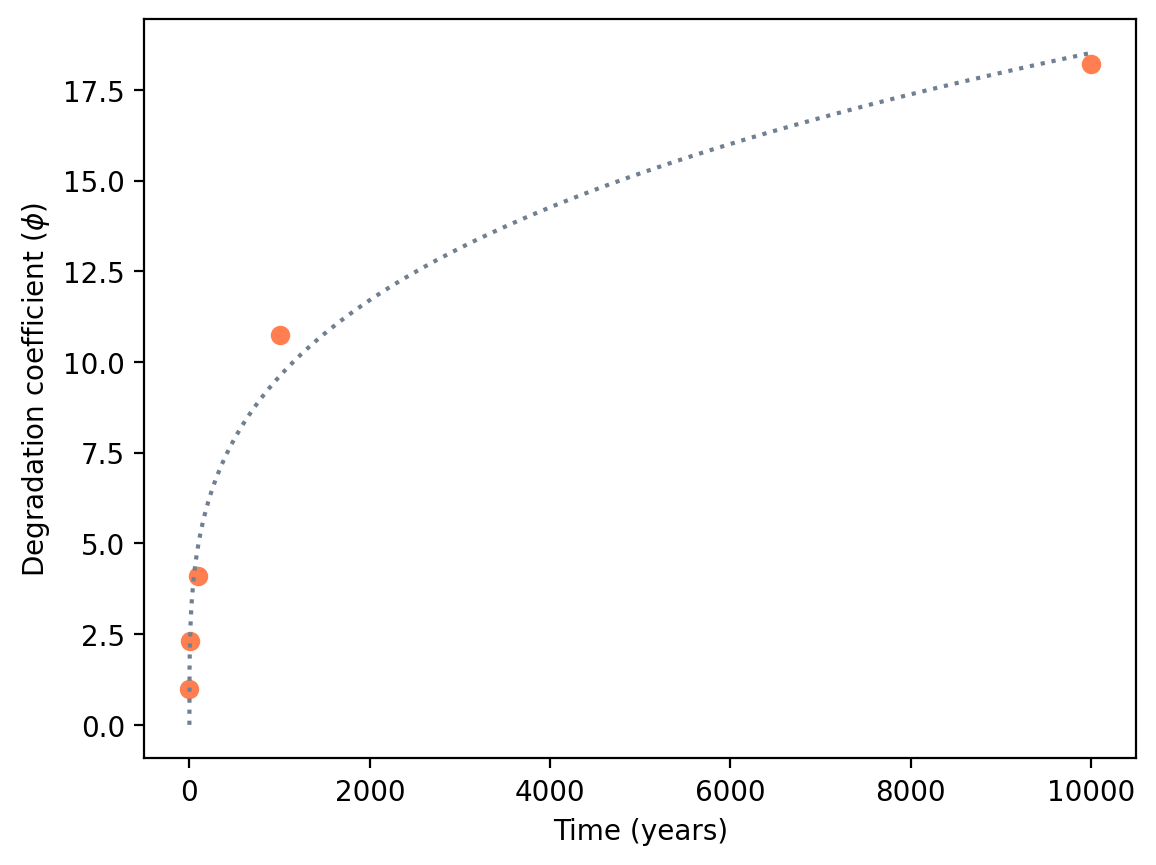

In [5]:
fig= plt.figure(
    dpi=200,
)

# landlab grid from DEM
mg, z = read_esri_ascii(DEM_name, name='topographic__elevation')
mg.set_fixed_value_boundaries_at_grid_edges(False, True, False, True)
mg.set_closed_boundaries_at_grid_edges(True, False, True, False)
slope_t0 = mg.calc_slope_at_node(z)
slope_t0 = np.array(slope_t0)
z_t0 = z[mg.nodes]

# model set-up for 2D diffusion
D = 0.01  # m2/yr transport rate
dt = 0.2 * mg.dx * mg.dx / D # time step is 5 years 
mg.set_closed_boundaries_at_grid_edges(True, False, True, False)
qs = mg.add_zeros('sediment_flux', at='link')

# run model over time
coeff_t = []

for p in range(max(n_iter)+1):
    if np.any(p == n_iter):
        slope_t = mg.calc_slope_at_node(z)
        slope_t = np.array(slope_t)
        ratio = slope_t0/slope_t
        ratio = ratio[np.logical_not(np.isnan(ratio))]
        ratio = np.mean(ratio)
        info_loss= ratio
        print(info_loss)
        coeff_t.append(info_loss)
        plt.scatter(p*dt,info_loss,color='coral')
    g = mg.calc_grad_at_link(z)
    qs[mg.active_links] = -D * g[mg.active_links]
    dzdt = -mg.calc_flux_div_at_node(qs)
    z[mg.core_nodes] += dzdt[mg.core_nodes] * dt  

def func(x,a,c):
    return x**a * c

time = np.zeros(5)
for n in range(len(n_iter)):
    time[n] = n_iter[n]*dt 
popt, pcov = curve_fit(func, time, coeff_t)
x = np.linspace(min(time),max(time),10000)
plt.plot(x,func(x, *popt),color='slategrey',linestyle=':')
plt.ylabel('Degradation coefficient ($\phi$)')
plt.xlabel('Time (years)')
plt.show()